## Imports

In [28]:
import numpy as np
from tqdm import trange

from kuramoto import Kuramoto
from kuramoto.db_metrics import *

from NNetwork import NNetwork as nn
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import svm
from sklearn import metrics, model_selection
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA ### Use truncated SVD / online PCA later for better computational efficiency

import warnings
warnings.filterwarnings("ignore")

## Plotting Functions

#### 1. Display Graphs

In [2]:
def display_graphs(title,
                     save_path,
                     grid_shape=[2,3],
                     fig_size=[10,10],
                     data = None, # [X, embs]
                     show_importance=False):

        # columns of X = vectorized k x k adjacency matrices
        # corresponding list in embs = sequence of nodes (may overalp)
        X, embs = data
        print('X.shape', X.shape)

        rows = grid_shape[0]
        cols = grid_shape[1]

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        # make outer gridspec

        idx = np.arange(X.shape[1])
        outer_grid = gridspec.GridSpec(nrows=rows, ncols=cols, wspace=0.02, hspace=0.02)

        # make nested gridspecs
        for i in range(rows * cols):
            a = i // cols
            b = i % rows

            Ndict_wspace = 0.05
            Ndict_hspace = 0.05

            # display graphs
            inner_grid = outer_grid[i].subgridspec(1, 1, wspace=Ndict_wspace, hspace=Ndict_hspace)

            # get rid of duplicate nodes
            A = X[:,idx[i]]
            A = X[:,idx[i]].reshape(int(np.sqrt(X.shape[0])), -1)
            H = nn.NNetwork()
            H.read_adj(A, embs[idx[i]])
            A_sub = H.get_adjacency_matrix()

            # read in as a nx graph for plotting
            G1 = nx.from_numpy_matrix(A_sub)
            ax = fig.add_subplot(inner_grid[0, 0])
            pos = nx.spring_layout(G1)
            edges = G1.edges()
            weights = [1*G1[u][v]['weight'] for u,v in edges]
            nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, label='Graph')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.suptitle(title, fontsize=15)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

#### 2. Display Dictionaries

In [3]:
def display_dictionary(W, dictionary_shape=None ,save_name=None, score=None, grid_shape=None, figsize=[10,10]):
    
    if dictionary_shape is None:
        k = int(np.sqrt(W.shape[0]))
        dict_shape = (k,k)
    else:
        dict_shape = dictionary_shape
        
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=figsize
    if (score is None) and (grid_shape is not None):
        figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
        figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

#### 3. Display both Graphs and Dictionaries

In [4]:
def display_dict_and_graph(title,
                           W,
                           singular_values, 
                           save_path,
                           grid_shape=None,
                           fig_size=[10,10],
                           show_importance=False,
                           only_show_matrices=True):
        
        n_components = W.shape[1]
        k = int(np.sqrt(W.shape[0]))

        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1

        if show_importance:
            # importance = np.sum(self.code, axis=1) / sum(sum(self.code))
            idx = np.argsort(singular_values)
            idx = np.flip(idx)
        else:
            idx = np.arange(W.shape[1])

        Ndict_wspace = 0.05
        Ndict_hspace = 0.05

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        ncols = 2 
        if only_show_matrices:
            ncols = 1
        outer_grid = gridspec.GridSpec(nrows=1, ncols=ncols, wspace=0.02, hspace=0.02)
        for t in np.arange(2):
            # make nested gridspecs

            if t == 0:
                ### Make gridspec
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
                    # ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                    # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                    ax.set_xticks([])
                    ax.set_yticks([])
            if (t == 1) and not only_show_matrices:
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols

                    G1 = nx.from_numpy_matrix(W[:,idx[i]].reshape(int(np.sqrt(W.shape[0])),-1))
                    ax = fig.add_subplot(inner_grid[a, b])
                    pos = nx.spring_layout(G1)
                    edges = G1.edges()
                    weights = [2*G1[u][v]['weight'] for u,v in edges]
                    nx.draw(G1, with_labels=False, node_size=10, ax=ax, width=weights, label='Graph')
                    if show_importance:
                        ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                        ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches

                    ax.set_xticks([])
                    ax.set_yticks([])

        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

## Dictionary Plotting Functions

In [238]:
def generate_nxg(get_patches_X):
    
    k = np.sqrt(X.shape[0])
    graph_list = []
    for i in range(X.shape[1]):
        adj_mat = X.T[i].reshape(k, k)
        G = nx.from_numpy_matrix(adj_mat)
        graph_list.append(G)
    
    return graph_list

def synchronization(colors):
    ordered = list(np.pi - colors); ordered.sort()
    lordered = len(ordered)
    
    threshold = np.pi
    if ordered == 0:
        assert("Empty array or logic error.")
    elif lordered == 1:
        return (0 < threshold)
    elif lordered == 2:
        dw = ordered[1]-ordered[0]
        if dw > threshold:
            return ((2*np.pi - dw) < threshold)
        else:
            return (dw < threshold)
    else:
        widths = [2*np.pi+ordered[0]-ordered[-1]]
        for i in range(lordered-1):
            widths.append(ordered[i+1]-ordered[i])
        return (np.abs(2*np.pi - max(widths)) < threshold)

## NMF Functions

In [5]:
def coding(X, W, H0, 
          r=None, 
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5], 
          stopping_grad_ratio=0.0001, 
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad 
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
    return H1


def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            #H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            #W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            W /= np.linalg.norm(W)
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

## Network Sampling - Caltech

In [218]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26, Caltech36
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 900
X.shape (2500, 900)


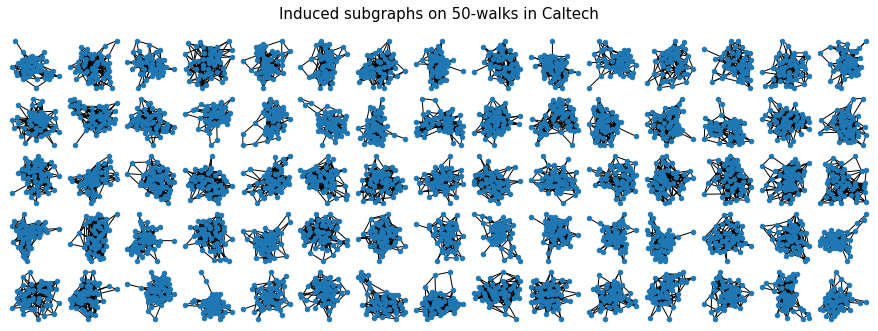

In [219]:
X, embs = G.get_patches(k=k, sample_size=900, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [220]:
W, H = ALS(X=X, 
           n_components=16, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  1%|▎                                   | 7/1000 [00:00<00:30, 32.25it/s]

iteration 0, reconstruction error 428509.032394


  2%|▌                                  | 17/1000 [00:00<00:24, 39.46it/s]

iteration 10, reconstruction error 296830.048247


  3%|▉                                  | 26/1000 [00:00<00:24, 39.71it/s]

iteration 20, reconstruction error 295114.278482


  4%|█▎                                 | 36/1000 [00:00<00:22, 41.91it/s]

iteration 30, reconstruction error 288040.668239


  5%|█▌                                 | 46/1000 [00:01<00:23, 41.23it/s]

iteration 40, reconstruction error 275462.902382


  6%|█▉                                 | 56/1000 [00:01<00:22, 41.66it/s]

iteration 50, reconstruction error 270717.354827


  7%|██▎                                | 66/1000 [00:01<00:23, 38.98it/s]

iteration 60, reconstruction error 268297.337236


  8%|██▋                                | 78/1000 [00:02<00:26, 35.02it/s]

iteration 70, reconstruction error 267009.858898


  9%|███                                | 86/1000 [00:02<00:26, 34.01it/s]

iteration 80, reconstruction error 266279.124265


 10%|███▎                               | 96/1000 [00:02<00:23, 38.83it/s]

iteration 90, reconstruction error 265820.682829


 11%|███▌                              | 106/1000 [00:02<00:21, 41.18it/s]

iteration 100, reconstruction error 265506.013118


 12%|███▉                              | 116/1000 [00:03<00:21, 41.05it/s]

iteration 110, reconstruction error 265273.734452


 13%|████▎                             | 126/1000 [00:03<00:21, 40.70it/s]

iteration 120, reconstruction error 265091.628930


 14%|████▌                             | 135/1000 [00:03<00:25, 33.39it/s]

iteration 130, reconstruction error 264943.422866


 15%|█████                             | 150/1000 [00:03<00:21, 39.47it/s]

iteration 140, reconstruction error 264818.222759


 16%|█████▍                            | 160/1000 [00:04<00:20, 41.47it/s]

iteration 150, reconstruction error 264709.905990


 16%|█████▌                            | 165/1000 [00:04<00:20, 40.64it/s]

iteration 160, reconstruction error 264614.526175


 18%|█████▉                            | 175/1000 [00:04<00:20, 41.05it/s]

iteration 170, reconstruction error 264529.214422


 19%|██████▍                           | 190/1000 [00:04<00:19, 41.70it/s]

iteration 180, reconstruction error 264452.166684


 20%|██████▊                           | 200/1000 [00:05<00:19, 41.89it/s]

iteration 190, reconstruction error 264381.900560


 21%|███████▏                          | 210/1000 [00:05<00:18, 42.31it/s]

iteration 200, reconstruction error 264317.439009


 22%|███████▍                          | 220/1000 [00:05<00:18, 42.61it/s]

iteration 210, reconstruction error 264257.882043


 23%|███████▊                          | 230/1000 [00:05<00:18, 42.63it/s]

iteration 220, reconstruction error 264202.538473


 24%|████████▏                         | 240/1000 [00:06<00:17, 42.91it/s]

iteration 230, reconstruction error 264151.144014


 24%|████████▎                         | 245/1000 [00:06<00:18, 41.70it/s]

iteration 240, reconstruction error 264103.273249


 26%|████████▋                         | 255/1000 [00:06<00:18, 40.92it/s]

iteration 250, reconstruction error 264058.312368


 27%|█████████▏                        | 270/1000 [00:06<00:17, 41.39it/s]

iteration 260, reconstruction error 264016.116259


 28%|█████████▎                        | 275/1000 [00:06<00:18, 39.76it/s]

iteration 270, reconstruction error 263976.489961


 29%|█████████▊                        | 290/1000 [00:07<00:17, 41.17it/s]

iteration 280, reconstruction error 263939.048599


 30%|██████████▏                       | 300/1000 [00:07<00:17, 41.06it/s]

iteration 290, reconstruction error 263903.603836


 31%|██████████▌                       | 310/1000 [00:07<00:16, 42.30it/s]

iteration 300, reconstruction error 263869.855418


 32%|██████████▉                       | 320/1000 [00:08<00:15, 43.30it/s]

iteration 310, reconstruction error 263837.709231


 33%|███████████▏                      | 330/1000 [00:08<00:15, 42.72it/s]

iteration 320, reconstruction error 263807.081089


 34%|███████████▌                      | 340/1000 [00:08<00:15, 43.02it/s]

iteration 330, reconstruction error 263777.952632


 34%|███████████▋                      | 345/1000 [00:08<00:15, 42.07it/s]

iteration 340, reconstruction error 263750.185469


 36%|████████████▏                     | 360/1000 [00:08<00:14, 43.98it/s]

iteration 350, reconstruction error 263723.606825


 36%|████████████▍                     | 365/1000 [00:09<00:14, 43.46it/s]

iteration 360, reconstruction error 263698.227516


 38%|████████████▉                     | 380/1000 [00:09<00:14, 42.90it/s]

iteration 370, reconstruction error 263674.054891


 39%|█████████████▎                    | 390/1000 [00:09<00:14, 42.60it/s]

iteration 380, reconstruction error 263650.943219


 40%|█████████████▍                    | 395/1000 [00:09<00:13, 43.76it/s]

iteration 390, reconstruction error 263628.812780


 40%|█████████████▊                    | 405/1000 [00:10<00:14, 41.47it/s]

iteration 400, reconstruction error 263607.494534


 42%|██████████████▎                   | 420/1000 [00:10<00:13, 43.48it/s]

iteration 410, reconstruction error 263586.917850


 43%|██████████████▌                   | 430/1000 [00:10<00:13, 42.31it/s]

iteration 420, reconstruction error 263567.050899


 44%|██████████████▉                   | 440/1000 [00:10<00:13, 42.34it/s]

iteration 430, reconstruction error 263547.856129


 44%|███████████████▏                  | 445/1000 [00:10<00:13, 40.52it/s]

iteration 440, reconstruction error 263529.367680


 46%|███████████████▍                  | 455/1000 [00:11<00:13, 39.61it/s]

iteration 450, reconstruction error 263511.544550


 46%|███████████████▊                  | 465/1000 [00:11<00:13, 39.89it/s]

iteration 460, reconstruction error 263494.395678


 48%|████████████████▎                 | 479/1000 [00:11<00:13, 38.90it/s]

iteration 470, reconstruction error 263477.879388


 49%|████████████████▌                 | 487/1000 [00:12<00:14, 34.87it/s]

iteration 480, reconstruction error 263461.935143


 50%|████████████████▊                 | 496/1000 [00:12<00:13, 37.52it/s]

iteration 490, reconstruction error 263446.538116


 50%|█████████████████▏                | 504/1000 [00:12<00:13, 36.85it/s]

iteration 500, reconstruction error 263431.649588


 52%|█████████████████▌                | 516/1000 [00:12<00:14, 34.08it/s]

iteration 510, reconstruction error 263417.248970


 52%|█████████████████▊                | 524/1000 [00:13<00:14, 33.20it/s]

iteration 520, reconstruction error 263403.354470


 54%|██████████████████▎               | 537/1000 [00:13<00:12, 35.78it/s]

iteration 530, reconstruction error 263389.925126


 55%|██████████████████▌               | 546/1000 [00:13<00:11, 40.01it/s]

iteration 540, reconstruction error 263376.951915


 56%|██████████████████▊               | 555/1000 [00:14<00:12, 36.03it/s]

iteration 550, reconstruction error 263364.431158


 57%|███████████████████▎              | 567/1000 [00:14<00:12, 34.50it/s]

iteration 560, reconstruction error 263352.326263


 57%|███████████████████▌              | 575/1000 [00:14<00:12, 33.69it/s]

iteration 570, reconstruction error 263340.598961


 59%|███████████████████▉              | 588/1000 [00:14<00:11, 34.79it/s]

iteration 580, reconstruction error 263329.224576


 60%|████████████████████▎             | 596/1000 [00:15<00:12, 32.26it/s]

iteration 590, reconstruction error 263318.195871


 61%|████████████████████▋             | 608/1000 [00:15<00:11, 35.16it/s]

iteration 600, reconstruction error 263307.498637


 62%|████████████████████▉             | 616/1000 [00:15<00:10, 37.12it/s]

iteration 610, reconstruction error 263297.105954


 63%|█████████████████████▎            | 628/1000 [00:16<00:09, 38.01it/s]

iteration 620, reconstruction error 263287.042694


 64%|█████████████████████▋            | 637/1000 [00:16<00:09, 39.30it/s]

iteration 630, reconstruction error 263277.290517


 64%|█████████████████████▉            | 645/1000 [00:16<00:09, 37.97it/s]

iteration 640, reconstruction error 263267.824696


 66%|██████████████████████▎           | 658/1000 [00:16<00:08, 38.76it/s]

iteration 650, reconstruction error 263258.643103


 67%|██████████████████████▋           | 667/1000 [00:17<00:08, 38.99it/s]

iteration 660, reconstruction error 263249.744102


 68%|██████████████████████▉           | 676/1000 [00:17<00:08, 39.00it/s]

iteration 670, reconstruction error 263241.109688


 69%|███████████████████████▎          | 686/1000 [00:17<00:07, 39.57it/s]

iteration 680, reconstruction error 263232.720969


 70%|███████████████████████▊          | 700/1000 [00:17<00:07, 41.00it/s]

iteration 690, reconstruction error 263224.569728


 71%|████████████████████████▏         | 710/1000 [00:18<00:06, 42.66it/s]

iteration 700, reconstruction error 263216.638378


 72%|████████████████████████▍         | 720/1000 [00:18<00:06, 41.69it/s]

iteration 710, reconstruction error 263208.927057


 72%|████████████████████████▋         | 725/1000 [00:18<00:06, 41.09it/s]

iteration 720, reconstruction error 263201.440485


 74%|████████████████████████▉         | 735/1000 [00:18<00:06, 40.90it/s]

iteration 730, reconstruction error 263194.169976


 74%|█████████████████████████▎        | 745/1000 [00:19<00:06, 41.80it/s]

iteration 740, reconstruction error 263187.098888


 76%|█████████████████████████▊        | 760/1000 [00:19<00:05, 44.06it/s]

iteration 750, reconstruction error 263180.223027


 77%|██████████████████████████▏       | 770/1000 [00:19<00:05, 43.23it/s]

iteration 760, reconstruction error 263173.545043


 78%|██████████████████████████▌       | 780/1000 [00:19<00:04, 44.06it/s]

iteration 770, reconstruction error 263167.051126


 79%|██████████████████████████▊       | 790/1000 [00:20<00:04, 43.99it/s]

iteration 780, reconstruction error 263160.725084


 80%|███████████████████████████▏      | 800/1000 [00:20<00:04, 44.08it/s]

iteration 790, reconstruction error 263154.555976


 81%|███████████████████████████▌      | 810/1000 [00:20<00:04, 42.89it/s]

iteration 800, reconstruction error 263148.541029


 82%|███████████████████████████▋      | 815/1000 [00:20<00:04, 41.65it/s]

iteration 810, reconstruction error 263142.671439


 83%|████████████████████████████▏     | 830/1000 [00:21<00:03, 42.62it/s]

iteration 820, reconstruction error 263136.946857


 84%|████████████████████████████▍     | 835/1000 [00:21<00:03, 42.08it/s]

iteration 830, reconstruction error 263131.366958


 85%|████████████████████████████▉     | 850/1000 [00:21<00:03, 42.52it/s]

iteration 840, reconstruction error 263125.931067


 86%|█████████████████████████████▏    | 860/1000 [00:21<00:03, 43.63it/s]

iteration 850, reconstruction error 263120.635875


 87%|█████████████████████████████▌    | 870/1000 [00:21<00:02, 43.61it/s]

iteration 860, reconstruction error 263115.471875


 88%|█████████████████████████████▊    | 875/1000 [00:22<00:02, 42.03it/s]

iteration 870, reconstruction error 263110.453405


 89%|██████████████████████████████▎   | 890/1000 [00:22<00:02, 42.09it/s]

iteration 880, reconstruction error 263105.573408


 90%|██████████████████████████████▌   | 900/1000 [00:22<00:02, 41.88it/s]

iteration 890, reconstruction error 263100.822689


 91%|██████████████████████████████▉   | 910/1000 [00:22<00:02, 42.92it/s]

iteration 900, reconstruction error 263096.199936


 92%|███████████████████████████████▎  | 920/1000 [00:23<00:01, 43.33it/s]

iteration 910, reconstruction error 263091.703220


 92%|███████████████████████████████▍  | 925/1000 [00:23<00:01, 41.43it/s]

iteration 920, reconstruction error 263087.331136


 94%|███████████████████████████████▉  | 940/1000 [00:23<00:01, 42.54it/s]

iteration 930, reconstruction error 263083.075467


 95%|████████████████████████████████▎ | 950/1000 [00:23<00:01, 42.57it/s]

iteration 940, reconstruction error 263078.931020


 96%|████████████████████████████████▍ | 955/1000 [00:23<00:01, 40.68it/s]

iteration 950, reconstruction error 263074.896108


 97%|████████████████████████████████▉ | 970/1000 [00:24<00:00, 41.47it/s]

iteration 960, reconstruction error 263070.961524


 98%|█████████████████████████████████▎| 980/1000 [00:24<00:00, 42.76it/s]

iteration 970, reconstruction error 263067.121680


 99%|█████████████████████████████████▋| 990/1000 [00:24<00:00, 43.63it/s]

iteration 980, reconstruction error 263063.373397


100%|█████████████████████████████████| 1000/1000 [00:25<00:00, 39.92it/s]

iteration 990, reconstruction error 263059.717130


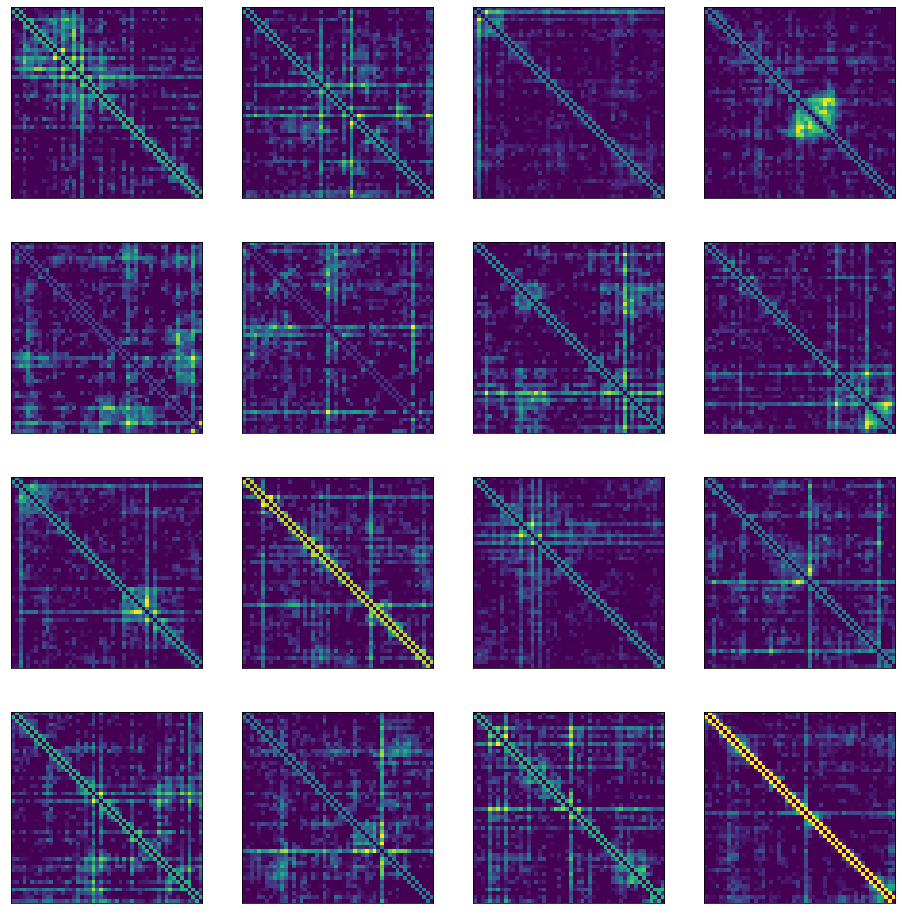

In [221]:
display_dictionary(W, figsize=[15,15])

In [222]:
def generate_nxg(get_patches_X):
    
    graph_list = []
    for i in range(X.shape[1]):
        adj_mat = X.T[i].reshape(50,50)
        G = nx.from_numpy_matrix(adj_mat)
        graph_list.append(G)
    
    return graph_list

def synchronization(colors):
    ordered = list(np.pi - colors); ordered.sort()
    lordered = len(ordered)
    
    threshold = np.pi
    if ordered == 0:
        assert("Empty array or logic error.")
    elif lordered == 1:
        return (0 < threshold)
    elif lordered == 2:
        dw = ordered[1]-ordered[0]
        if dw > threshold:
            return ((2*np.pi - dw) < threshold)
        else:
            return (dw < threshold)
    else:
        widths = [2*np.pi+ordered[0]-ordered[-1]]
        for i in range(lordered-1):
            widths.append(ordered[i+1]-ordered[i])
        return (np.abs(2*np.pi - max(widths)) < threshold)

In [223]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 900


In [228]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 3

for G in graph_list:
    
    headers = []
    for i in range(1, nodes+1):
        for j in range(1, r+1):
            headers.append(f's{i}_{j}')
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, base_iter=r, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,True
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
896,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
898,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,True


In [229]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.7811111111111111


In [230]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [231]:
print(X_true.shape)
print(X_false.shape)

(2500, 703)
(2500, 197)


In [232]:
W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  1%|▍                                  | 12/1000 [00:00<00:17, 57.53it/s]

iteration 0, reconstruction error 337408.952774
iteration 10, reconstruction error 233666.026125


  3%|█                                  | 31/1000 [00:00<00:16, 59.00it/s]

iteration 20, reconstruction error 231615.779388
iteration 30, reconstruction error 224356.022539


  5%|█▋                                 | 49/1000 [00:00<00:16, 57.16it/s]

iteration 40, reconstruction error 215452.165974
iteration 50, reconstruction error 212067.293312


  7%|██▎                                | 67/1000 [00:01<00:16, 56.53it/s]

iteration 60, reconstruction error 210325.175370
iteration 70, reconstruction error 209395.596673


  9%|███▏                               | 92/1000 [00:01<00:15, 56.92it/s]

iteration 80, reconstruction error 208850.533716
iteration 90, reconstruction error 208494.949443


 11%|███▋                              | 110/1000 [00:01<00:16, 52.85it/s]

iteration 100, reconstruction error 208242.318894
iteration 110, reconstruction error 208049.939553


 13%|████▍                             | 129/1000 [00:02<00:15, 55.25it/s]

iteration 120, reconstruction error 207896.017494
iteration 130, reconstruction error 207769.794815


 15%|████▉                             | 147/1000 [00:02<00:16, 52.99it/s]

iteration 140, reconstruction error 207663.939010
iteration 150, reconstruction error 207573.496842


 17%|█████▊                            | 171/1000 [00:03<00:14, 55.55it/s]

iteration 160, reconstruction error 207495.530603
iteration 170, reconstruction error 207427.311509


 19%|██████▍                           | 190/1000 [00:03<00:14, 56.93it/s]

iteration 180, reconstruction error 207366.647999
iteration 190, reconstruction error 207312.368400


 21%|███████                           | 207/1000 [00:03<00:16, 47.71it/s]

iteration 200, reconstruction error 207263.373979


 22%|███████▍                          | 218/1000 [00:04<00:20, 37.35it/s]

iteration 210, reconstruction error 207218.636971


 23%|███████▊                          | 228/1000 [00:04<00:19, 40.34it/s]

iteration 220, reconstruction error 207177.438457


 24%|████████                          | 238/1000 [00:04<00:18, 40.56it/s]

iteration 230, reconstruction error 207139.551534


 25%|████████▍                         | 249/1000 [00:04<00:17, 44.16it/s]

iteration 240, reconstruction error 207104.375539


 26%|████████▊                         | 260/1000 [00:05<00:15, 46.66it/s]

iteration 250, reconstruction error 207071.459485
iteration 260, reconstruction error 207040.632418


 28%|█████████▍                        | 278/1000 [00:05<00:13, 52.63it/s]

iteration 270, reconstruction error 207011.690514
iteration 280, reconstruction error 206984.450523


 30%|██████████                        | 296/1000 [00:05<00:14, 48.64it/s]

iteration 290, reconstruction error 206958.791350
iteration 300, reconstruction error 206934.553692


 32%|██████████▉                       | 321/1000 [00:06<00:12, 55.17it/s]

iteration 310, reconstruction error 206911.689512
iteration 320, reconstruction error 206890.047669


 34%|███████████▌                      | 339/1000 [00:06<00:11, 56.77it/s]

iteration 330, reconstruction error 206869.500836
iteration 340, reconstruction error 206850.017022


 36%|████████████▏                     | 357/1000 [00:06<00:11, 55.35it/s]

iteration 350, reconstruction error 206831.474213
iteration 360, reconstruction error 206813.830992


 38%|████████████▉                     | 381/1000 [00:07<00:10, 56.60it/s]

iteration 370, reconstruction error 206797.019288
iteration 380, reconstruction error 206781.009431


 40%|█████████████▌                    | 400/1000 [00:07<00:10, 57.69it/s]

iteration 390, reconstruction error 206765.724822
iteration 400, reconstruction error 206751.120111


 42%|██████████████▏                   | 418/1000 [00:08<00:10, 56.28it/s]

iteration 410, reconstruction error 206737.161816
iteration 420, reconstruction error 206723.800205


 44%|██████████████▉                   | 438/1000 [00:08<00:09, 57.99it/s]

iteration 430, reconstruction error 206711.005492
iteration 440, reconstruction error 206698.722485


 46%|███████████████▋                  | 462/1000 [00:08<00:09, 56.21it/s]

iteration 450, reconstruction error 206686.910347
iteration 460, reconstruction error 206675.537503


 48%|████████████████▎                 | 480/1000 [00:09<00:09, 57.51it/s]

iteration 470, reconstruction error 206664.595899
iteration 480, reconstruction error 206654.043751


 50%|████████████████▉                 | 499/1000 [00:09<00:08, 58.54it/s]

iteration 490, reconstruction error 206643.875463
iteration 500, reconstruction error 206634.068308


 52%|█████████████████▌                | 517/1000 [00:09<00:09, 50.92it/s]

iteration 510, reconstruction error 206624.593511


 53%|█████████████████▉                | 529/1000 [00:10<00:09, 52.08it/s]

iteration 520, reconstruction error 206615.446221
iteration 530, reconstruction error 206606.614627


 55%|██████████████████▋               | 548/1000 [00:10<00:08, 56.28it/s]

iteration 540, reconstruction error 206598.084661
iteration 550, reconstruction error 206589.852311


 57%|███████████████████▍              | 572/1000 [00:10<00:07, 55.45it/s]

iteration 560, reconstruction error 206581.909187
iteration 570, reconstruction error 206574.226806


 59%|████████████████████              | 590/1000 [00:11<00:07, 56.55it/s]

iteration 580, reconstruction error 206566.798942
iteration 590, reconstruction error 206559.580538


 61%|████████████████████▋             | 608/1000 [00:11<00:06, 56.73it/s]

iteration 600, reconstruction error 206552.558485
iteration 610, reconstruction error 206545.711864


 63%|█████████████████████▎            | 628/1000 [00:11<00:06, 58.78it/s]

iteration 620, reconstruction error 206539.040519
iteration 630, reconstruction error 206532.540489


 65%|██████████████████████▏           | 652/1000 [00:12<00:06, 57.29it/s]

iteration 640, reconstruction error 206526.185244
iteration 650, reconstruction error 206519.975403


 67%|██████████████████████▊           | 670/1000 [00:12<00:06, 52.32it/s]

iteration 660, reconstruction error 206513.912812
iteration 670, reconstruction error 206507.988730


 69%|███████████████████████▍          | 689/1000 [00:12<00:05, 55.92it/s]

iteration 680, reconstruction error 206502.191957
iteration 690, reconstruction error 206496.521910


 71%|████████████████████████          | 708/1000 [00:13<00:05, 58.15it/s]

iteration 700, reconstruction error 206490.965802
iteration 710, reconstruction error 206485.513577


 73%|████████████████████████▉         | 733/1000 [00:13<00:04, 58.79it/s]

iteration 720, reconstruction error 206480.157062
iteration 730, reconstruction error 206474.885977


 75%|█████████████████████████▌        | 751/1000 [00:13<00:04, 57.20it/s]

iteration 740, reconstruction error 206469.693018
iteration 750, reconstruction error 206464.577604


 77%|██████████████████████████▏       | 770/1000 [00:14<00:03, 58.78it/s]

iteration 760, reconstruction error 206459.531856
iteration 770, reconstruction error 206454.550371


 79%|██████████████████████████▊       | 789/1000 [00:14<00:03, 60.23it/s]

iteration 780, reconstruction error 206449.631801
iteration 790, reconstruction error 206444.775401


 81%|███████████████████████████▍      | 808/1000 [00:14<00:03, 56.37it/s]

iteration 800, reconstruction error 206439.977770
iteration 810, reconstruction error 206435.238478


 83%|████████████████████████████      | 827/1000 [00:15<00:03, 55.92it/s]

iteration 820, reconstruction error 206430.556973
iteration 830, reconstruction error 206425.928593


 85%|█████████████████████████████     | 853/1000 [00:15<00:02, 57.64it/s]

iteration 840, reconstruction error 206421.347190
iteration 850, reconstruction error 206416.802799


 87%|█████████████████████████████▌    | 871/1000 [00:16<00:02, 56.68it/s]

iteration 860, reconstruction error 206412.292843
iteration 870, reconstruction error 206407.812318


 89%|██████████████████████████████▎   | 890/1000 [00:16<00:01, 59.87it/s]

iteration 880, reconstruction error 206403.354332
iteration 890, reconstruction error 206398.913073


 91%|██████████████████████████████▉   | 909/1000 [00:16<00:01, 58.42it/s]

iteration 900, reconstruction error 206394.489141
iteration 910, reconstruction error 206390.085404


 93%|███████████████████████████████▌  | 927/1000 [00:17<00:01, 56.71it/s]

iteration 920, reconstruction error 206385.708369
iteration 930, reconstruction error 206381.357280


 95%|████████████████████████████████▍ | 953/1000 [00:17<00:00, 58.69it/s]

iteration 940, reconstruction error 206377.027030
iteration 950, reconstruction error 206372.714859


 97%|█████████████████████████████████ | 972/1000 [00:17<00:00, 59.01it/s]

iteration 960, reconstruction error 206368.427125
iteration 970, reconstruction error 206364.166478


 99%|█████████████████████████████████▋| 991/1000 [00:18<00:00, 58.72it/s]

iteration 980, reconstruction error 206359.936650
iteration 990, reconstruction error 206355.743288


100%|█████████████████████████████████| 1000/1000 [00:18<00:00, 54.62it/s]




###########################
Shape of W_true: (2500, 16)
###########################




  1%|▎                                 | 11/1000 [00:00<00:09, 106.66it/s]

iteration 0, reconstruction error 91071.036905
iteration 10, reconstruction error 62349.731112
iteration 20, reconstruction error 58830.737202


  6%|█▉                                | 57/1000 [00:00<00:06, 141.68it/s]

iteration 30, reconstruction error 55655.712337
iteration 40, reconstruction error 54395.696568
iteration 50, reconstruction error 53778.173922


  9%|██▉                               | 86/1000 [00:00<00:06, 138.22it/s]

iteration 60, reconstruction error 53431.817312
iteration 70, reconstruction error 53210.783666
iteration 80, reconstruction error 53054.476270


 11%|███▊                             | 114/1000 [00:00<00:07, 123.12it/s]

iteration 90, reconstruction error 52936.090079
iteration 100, reconstruction error 52842.855327
iteration 110, reconstruction error 52767.365978


 14%|████▋                            | 142/1000 [00:01<00:06, 131.94it/s]

iteration 120, reconstruction error 52703.279394
iteration 130, reconstruction error 52648.419645
iteration 140, reconstruction error 52600.889492


 17%|█████▋                           | 171/1000 [00:01<00:06, 132.89it/s]

iteration 150, reconstruction error 52559.001120
iteration 160, reconstruction error 52521.310261
iteration 170, reconstruction error 52487.124164


 20%|██████▌                          | 200/1000 [00:01<00:05, 136.41it/s]

iteration 180, reconstruction error 52455.950501
iteration 190, reconstruction error 52427.139766
iteration 200, reconstruction error 52400.389896
iteration 210, reconstruction error 52375.276767


 24%|████████                         | 243/1000 [00:01<00:05, 140.18it/s]

iteration 220, reconstruction error 52351.554738
iteration 230, reconstruction error 52329.433290
iteration 240, reconstruction error 52308.631783


 27%|█████████                        | 273/1000 [00:02<00:05, 137.53it/s]

iteration 250, reconstruction error 52288.721935
iteration 260, reconstruction error 52269.688686
iteration 270, reconstruction error 52251.477667


 30%|█████████▉                       | 301/1000 [00:02<00:05, 133.99it/s]

iteration 280, reconstruction error 52233.917888
iteration 290, reconstruction error 52216.901981
iteration 300, reconstruction error 52200.429715


 33%|██████████▉                      | 330/1000 [00:02<00:04, 137.91it/s]

iteration 310, reconstruction error 52184.396002
iteration 320, reconstruction error 52168.752140
iteration 330, reconstruction error 52153.551058


 36%|███████████▊                     | 358/1000 [00:02<00:04, 133.14it/s]

iteration 340, reconstruction error 52138.841342
iteration 350, reconstruction error 52124.696546
iteration 360, reconstruction error 52111.049618


 39%|████████████▊                    | 387/1000 [00:02<00:04, 134.65it/s]

iteration 370, reconstruction error 52097.827462
iteration 380, reconstruction error 52085.123434
iteration 390, reconstruction error 52072.842955


 42%|█████████████▋                   | 416/1000 [00:03<00:04, 134.84it/s]

iteration 400, reconstruction error 52061.030938
iteration 410, reconstruction error 52049.697095
iteration 420, reconstruction error 52038.782117


 44%|██████████████▋                  | 445/1000 [00:03<00:04, 133.74it/s]

iteration 430, reconstruction error 52028.273446
iteration 440, reconstruction error 52018.144387
iteration 450, reconstruction error 52008.338337


 48%|███████████████▋                 | 476/1000 [00:03<00:03, 139.70it/s]

iteration 460, reconstruction error 51998.836531
iteration 470, reconstruction error 51989.715271
iteration 480, reconstruction error 51980.923312


 52%|█████████████████▏               | 519/1000 [00:03<00:03, 139.04it/s]

iteration 490, reconstruction error 51972.427260
iteration 500, reconstruction error 51964.248396
iteration 510, reconstruction error 51956.408392


 55%|██████████████████               | 549/1000 [00:04<00:03, 142.99it/s]

iteration 520, reconstruction error 51948.831585
iteration 530, reconstruction error 51941.460400
iteration 540, reconstruction error 51934.352170


 58%|███████████████████              | 579/1000 [00:04<00:02, 141.90it/s]

iteration 550, reconstruction error 51927.500785
iteration 560, reconstruction error 51920.848374
iteration 570, reconstruction error 51914.383766


 61%|████████████████████             | 608/1000 [00:04<00:02, 133.69it/s]

iteration 580, reconstruction error 51908.085789
iteration 590, reconstruction error 51901.907505
iteration 600, reconstruction error 51895.871617


 64%|████████████████████▉            | 636/1000 [00:04<00:02, 131.22it/s]

iteration 610, reconstruction error 51889.946182
iteration 620, reconstruction error 51884.123126
iteration 630, reconstruction error 51878.396727


 66%|█████████████████████▉           | 665/1000 [00:04<00:02, 136.63it/s]

iteration 640, reconstruction error 51872.740794
iteration 650, reconstruction error 51867.174022
iteration 660, reconstruction error 51861.721525


 69%|██████████████████████▉          | 694/1000 [00:05<00:02, 137.19it/s]

iteration 670, reconstruction error 51856.354947
iteration 680, reconstruction error 51851.089820
iteration 690, reconstruction error 51845.906820


 72%|███████████████████████▊         | 721/1000 [00:05<00:02, 125.20it/s]

iteration 700, reconstruction error 51840.798215
iteration 710, reconstruction error 51835.744923
iteration 720, reconstruction error 51830.737927


 75%|████████████████████████▋        | 749/1000 [00:05<00:01, 129.42it/s]

iteration 730, reconstruction error 51825.766188
iteration 740, reconstruction error 51820.846878
iteration 750, reconstruction error 51815.977689


 78%|█████████████████████████▋       | 778/1000 [00:05<00:01, 134.00it/s]

iteration 760, reconstruction error 51811.144932
iteration 770, reconstruction error 51806.369710
iteration 780, reconstruction error 51801.664488
iteration 790, reconstruction error 51797.067978


 82%|███████████████████████████▏     | 822/1000 [00:06<00:01, 137.75it/s]

iteration 800, reconstruction error 51792.559709
iteration 810, reconstruction error 51788.139458
iteration 820, reconstruction error 51783.833288


 85%|████████████████████████████     | 852/1000 [00:06<00:01, 141.15it/s]

iteration 830, reconstruction error 51779.668596
iteration 840, reconstruction error 51775.612143
iteration 850, reconstruction error 51771.662320


 88%|█████████████████████████████    | 881/1000 [00:06<00:00, 136.38it/s]

iteration 860, reconstruction error 51767.844827
iteration 870, reconstruction error 51764.133203
iteration 880, reconstruction error 51760.526521


 91%|█████████████████████████████▉   | 909/1000 [00:06<00:00, 134.70it/s]

iteration 890, reconstruction error 51757.031183
iteration 900, reconstruction error 51753.640225
iteration 910, reconstruction error 51750.354166


 94%|██████████████████████████████▉  | 938/1000 [00:06<00:00, 135.66it/s]

iteration 920, reconstruction error 51747.170848
iteration 930, reconstruction error 51744.096739
iteration 940, reconstruction error 51741.118920


 97%|███████████████████████████████▉ | 966/1000 [00:07<00:00, 132.34it/s]

iteration 950, reconstruction error 51738.241309
iteration 960, reconstruction error 51735.467228
iteration 970, reconstruction error 51732.777362


100%|████████████████████████████████| 1000/1000 [00:07<00:00, 134.53it/s]

iteration 980, reconstruction error 51730.168877
iteration 990, reconstruction error 51727.664878


###########################
Shape of W_false: (2500, 16)
###########################




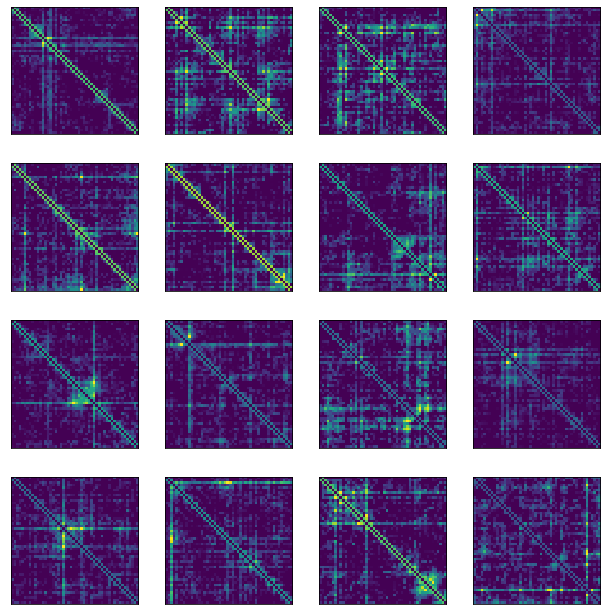

In [233]:
display_dictionary(W_true, figsize=[10,10])

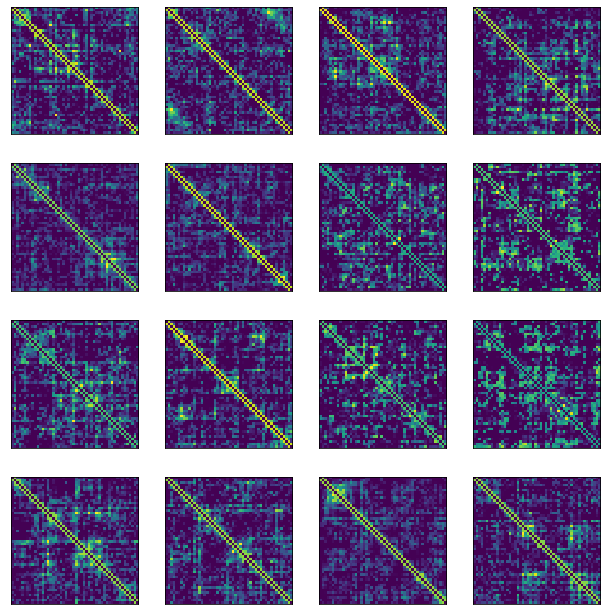

In [234]:
display_dictionary(W_false, figsize=[10,10])

In [235]:
def display_dict_and_graph(title=None,
                             save_path=None,
                             grid_shape=None,
                             fig_size=[10,10],
                             W = None,
                             At = None,
                             plot_graph_only=False,
                             show_importance=False):
        n_components = W.shape[1]
        k = int(np.sqrt(W.shape[0]))
        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1
        if At is None:
            idx = np.arange(W.shape[1])
        else:
            importance = np.sqrt(At.diagonal()) / sum(np.sqrt(At.diagonal()))
            # importance = np.sum(self.code, axis=1) / sum(sum(self.code))
            idx = np.argsort(importance)
            idx = np.flip(idx)
        Ndict_wspace = 0.05
        Ndict_hspace = 0.05
        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        ncols = 2
        if plot_graph_only:
            ncols =1
        outer_grid = gridspec.GridSpec(nrows=1, ncols=ncols, wspace=0.02, hspace=0.05)
        for t in np.arange(ncols):
            # make nested gridspecs
            if t == 1:
                ### Make gridspec
                inner_grid = outer_grid[1].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)
                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    ax.imshow(W.T[idx[i]].reshape(k, k), cmap="gray_r", interpolation='nearest')
                    # ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                    # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                    ax.set_xticks([])
                    ax.set_yticks([])
            if t == 0:
                inner_grid = outer_grid[0].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)
                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    k = int(np.sqrt(W.shape[0]))
                    A_sub = W[:,idx[i]].reshape(k,k)
                    H = nx.from_numpy_matrix(A_sub)
                    G1 = nx.Graph()
                    for a in np.arange(k):
                        for b in np.arange(k):
                            u = list(H.nodes())[a]
                            v = list(H.nodes())[b]
                            if H.has_edge(u,v):
                                if np.abs(a-b) == 1:
                                    G1.add_edge(u,v, color='r', weight=A_sub[a,b])
                                else:
                                    G1.add_edge(u,v, color='b', weight=A_sub[a,b])
                    pos = nx.spring_layout(G1)
                    edges = G1.edges()
                    colors = [G1[u][v]['color'] for u,v in edges]
                    weights = [100*G1[u][v]['weight'] for u,v in edges]
                    nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, edge_color=colors, label='Graph')
                    
                    ## Fix this
                    if show_importance:
                        ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                        ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
#                     ax.set_xticks([])
#                     ax.set_yticks([])
        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        if save_path is not None:
            fig.savefig(save_path, bbox_inches='tight')

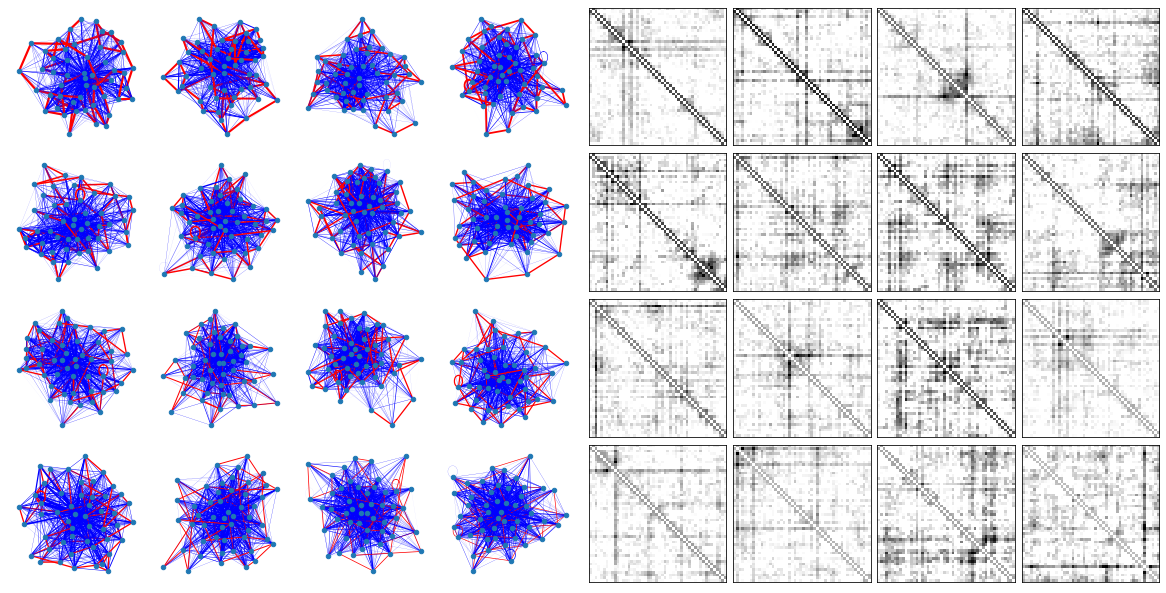

In [236]:
display_dict_and_graph(W=W_true, At = np.dot(H_true, H_true.T), fig_size=[20,10], show_importance=True)

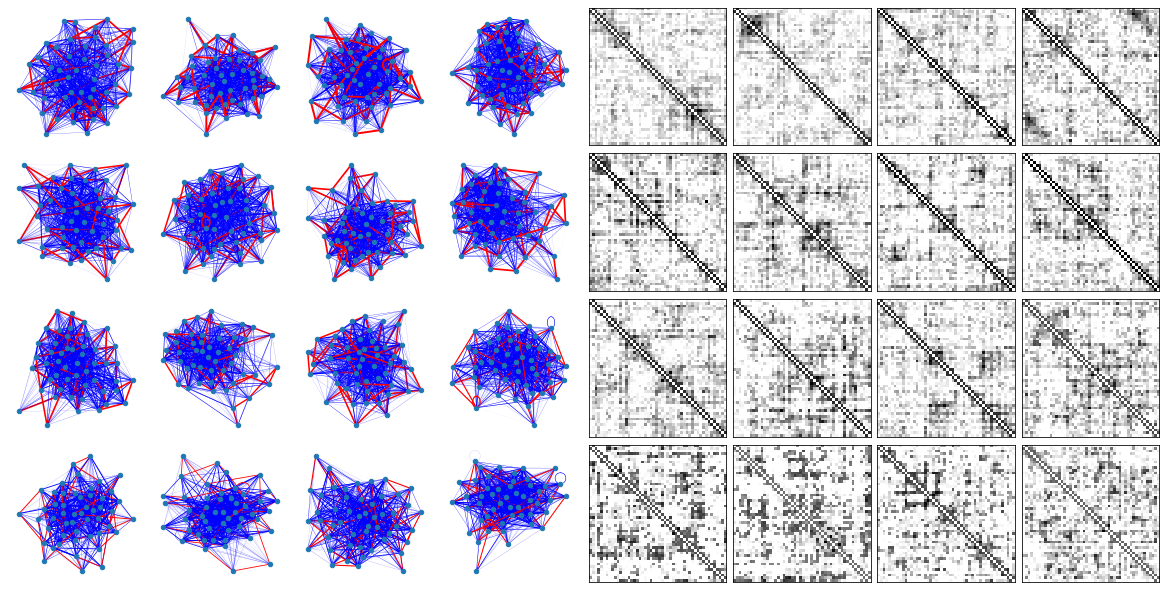

In [237]:
display_dict_and_graph(W=W_false, At = np.dot(H_false, H_false.T), fig_size=[20,10], show_importance=True)